Import Libraries

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Function to Smooth the Signal

In [82]:
# Function to smooth the behavioral signal using a Gaussian window - as we've been taught in the Tirgul with Chemda).
def find_finger_events(tr):
    # Create a Gaussian window of size 80
    x = np.arange(1, 81)
    gs = np.exp(-((x - 40)**2) / 160)
    gs_norm = gs / np.sum(gs)  # Normalize to sum to 1
    
    # Apply convolution between the signal and the Gaussian window
    tra = np.convolve(tr, gs_norm, mode='same')
    return tra


Function to Detect Event Start Points

In [83]:
# Function to detect event start points and local minima (as we've been taught in the Tirgul with Chemda)
def find_event_starts(tra):
    thresh = np.mean(tra) + np.std(tra)
    
    # Identify points exceeding the threshold
    a1 = tra > thresh
    
    # Find maxima
    a2_tra = np.concatenate([tra[1:], [0]])  
    a3_tra = np.concatenate([[0], tra[:-1]])  
    a2 = (tra - a2_tra) > 0
    a3 = (tra - a3_tra) > 0
    a = np.where(a1 & a2 & a3)[0]  
    
    # Find local minima points
    b2 = np.diff(np.concatenate(([0], tra))) < 0  
    b3 = np.diff(np.concatenate((tra, [0]))) > 0  
    closest_min = np.where(b2 & b3)[0]  
    
    return a, closest_min


Main Function to Calculate ERP

In [84]:
def calc_mean_erp(trial_points, ecog_data):
    """
    Compute the Event-Related Potential (ERP) for each finger movement.
    
    Parameters:
    - trial_points: CSV file with columns ['start', 'peak', 'finger'].
    - ecog_data: CSV file containing the brain signal (one column).
    
    Returns:
    - ERP matrix (5x1201): Average brain response for each finger.
    - Visualization of the ERP for all fingers.
    """
    # Load the input data
    trial_points_from_csv = pd.read_csv(trial_points, names=['start', 'peak', 'finger'], header=0)
    ecog_data_from_csv = pd.read_csv(ecog_data, header=None).squeeze()
    
    # Parameters for ERP extraction
    pre_start = 200  # Pre-movement samples
    post_start = 1000  # Post-movement samples
    window_length = pre_start + post_start + 1  # Total samples per window
    
    # Store the signal windows for each finger
    signals_by_finger = {finger: [] for finger in range(1, 6)}

    # Extract brain signal segments for each trial
    for _, trial in trial_points_from_csv.iterrows():
        start_index = int(trial['start'])
        finger_id = int(trial['finger'])

        # Ensure the window is within bounds
        if start_index - pre_start >= 0 and start_index + post_start < len(ecog_data_from_csv):
            signal_segment = ecog_data_from_csv[start_index - pre_start:start_index + post_start + 1]
            signals_by_finger[finger_id].append(signal_segment)

    # Compute the average ERP for each finger
    fingers_erp_mean = []
    for finger_id in range(1, 6):
        if signals_by_finger[finger_id]:
            avg_signal = np.mean(signals_by_finger[finger_id], axis=0)
            fingers_erp_mean.append(avg_signal)
        else:
            fingers_erp_mean.append(np.zeros(window_length))

    fingers_erp_mean = np.array(fingers_erp_mean)

    # Plot the ERP
    plt.figure(figsize=(10, 6))
    for finger_id, avg_signal in enumerate(fingers_erp_mean, start=1):
        plt.plot(avg_signal, label=f"Finger {finger_id}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")
    plt.title("ERP for Each Finger")
    plt.legend()
    plt.grid(True)
    plt.show()

    return fingers_erp_mean


Load and Process the Data

In [85]:
# Load the finger data and preprocess it
finger_data_file = '../../data/finger_data.csv'
finger_data = pd.read_csv(finger_data_file).iloc[:, 0]  # Use the first column as the behavioral signal

# Smooth the signal using the Gaussian window
smoothed_signal = find_finger_events(finger_data)

# Detect the start points and local minima
start_points, local_minima = find_event_starts(smoothed_signal)


Save the ERP matrix to a CSV file

In [86]:
# Save the ERP matrix to a CSV file
def save_erp_to_csv(fingers_erp_mean, output_file="../../data/fingers_erp_mean.csv"):
    # Convert the ERP matrix into a DataFrame
    erp_df = pd.DataFrame(fingers_erp_mean)
    
    # Rename rows and columns for better understanding
    erp_df.index = [f"Finger {i}" for i in range(1, 6)]  # Row names: Finger 1, Finger 2, etc.
    erp_df.columns = [f"Time {i}" for i in range(erp_df.shape[1])]  # Column names: Time 1, Time 2, etc.
    
    # Save the DataFrame to a CSV file
    erp_df.to_csv(output_file, index=True)


Calculate and Plot ERP

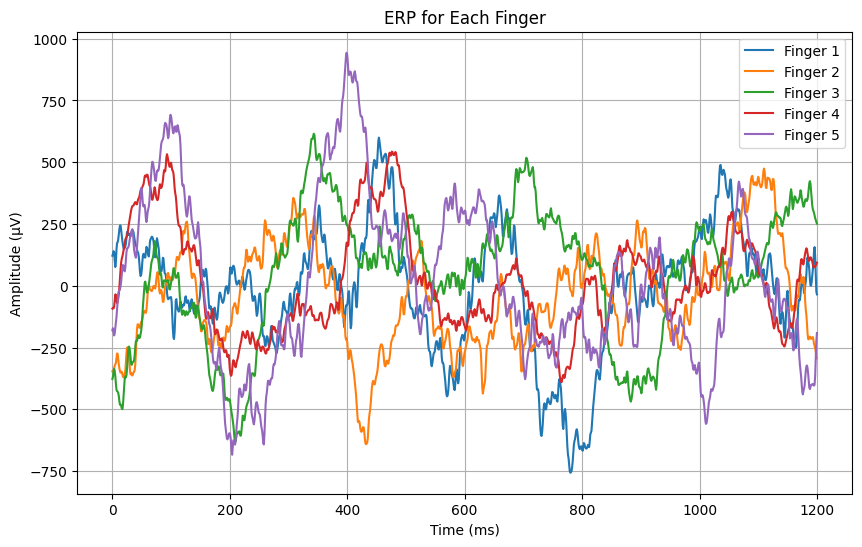

ERP Matrix (5x1201):
[[ 121.5859375   128.078125    140.1796875  ...   42.8125
   -23.765625    -34.859375  ]
 [-346.25210084 -345.36134454 -342.79831933 ... -267.57983193
  -281.78991597 -293.69747899]
 [-377.33333333 -367.99166667 -346.64166667 ...  265.88333333
   258.375       251.18333333]
 [ -92.44736842  -89.54210526  -91.61578947 ...   81.10526316
    87.2          93.63684211]
 [-180.35135135 -171.59459459 -185.48648649 ... -294.05405405
  -222.86486486 -191.21621622]]


In [87]:
# File paths for trial points and brain signal data
trial_points_file = '../../data/events_file_ordered.csv'
ecog_data_file = '../../data/brain_data_channel_one.csv'

# Calculate the ERP and obtain the ERP matrix
fingers_erp_mean  = calc_mean_erp(trial_points_file, ecog_data_file)

# Print the ERP matrix
print("ERP Matrix (5x1201):")
save_erp_to_csv(fingers_erp_mean)
print(fingers_erp_mean )
